In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from tqdm import tqdm


def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk

In [2]:
# Check differences between two was of calculating values. 
from trajectory.planner import accel_acd, accel_xt

rows = []
for v_0, v_c, v_1 in tqdm(list(product(velocities,velocities, velocities))):
    x_ad, t_ad = accel_acd(v_0, v_c, v_1, a_max)
    
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)
    
    rows.append( dict(x = x_ad - (x_a+x_d), t = t_ad -(t_a+t_d) ))
    
df = pd.DataFrame(rows)
                
df.describe()
    

100%|██████████| 13824/13824 [00:00<00:00, 301465.46it/s]


,x,t
count,1.382400e+04,1.382400e+04
mean,-4.584248e-16,-5.398423e-19
std,1.117347e-14,6.388327e-18
min,-5.684342e-14,-2.775558e-17
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.136868e-13,2.775558e-17


<AxesSubplot:xlabel='x'>

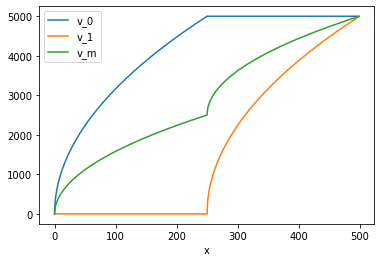

In [3]:
# Boundary Value reduction
j = Joint(5_000, 50_000)
rows = []
for x in range(500):
    v_0, v_1 = set_bv(x, v_max, v_max, a_max)
    rows.append(dict(x=x,v_0=v_0, v_1=v_1, v_m=(v_0+v_1)/2))

df = pd.DataFrame(rows)
df.set_index('x').plot()

In [4]:
# Test that values get passed through the Block sontructors. 
from trajectory.planner import  Block, Joint

j = Joint(5_000, 50_000)
b = j.new_block(100,123,456)

assert b.x == 100, b.x
assert b.v_0 == 123
assert b.joint.v_max == 5_000

b = j.new_block(100,123,456)

assert b.x == 100
assert b.v_0 == 123
assert b.joint.v_max == 5_000


In [5]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import consistantize, Joint, SegmentList

# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert abs(b.area-b.x) < 1, (b, i)
            t = b.t*tf
            b.plan(t)
            assert abs(b.area - b.x)<3, (b.area, b, i, b.flag)
            if b.t != t:
                ot = b.t
                b.plan(ot)
                #assert round(b.t, 6) == round(ot, 6), (b.t, t)
                
            x_c, x_e = consistantize(b, True)
            a = b.area
        except:
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, x_e = x_e, a=a, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df))
df.qc.value_counts(normalize=True)

100%|██████████| 11520/11520 [00:44<00:00, 258.82it/s]


# rows = 115200


O     0.751944
NT    0.198056
Z     0.050000
Name: qc, dtype: float64

In [6]:
df.sort_values('x_e', ascending=False)

,i,x,t,v_0,v_1,v_c,x_e,a,qc
13299,1329,20,0.040490,0.305176,0.0,1012.393490,0.498811,20.498811,NT
60372,6037,251,0.141836,0.274658,0.0,3546.033488,0.487069,251.487069,NT
33375,3337,50,0.048624,1118.033989,0.0,1774.621031,0.485596,50.485596,O
34370,3437,50,0.048623,1118.033989,0.0,1774.585075,0.483044,50.483044,O
31536,3153,50,0.048623,1118.033989,0.0,1774.583135,0.482906,50.482906,O
...,...,...,...,...,...,...,...,...,...
62731,6273,251,0.141560,0.289917,0.0,3539.136624,-0.490240,250.509760,NT
30874,3087,50,0.062923,0.366211,0.0,1573.267416,-0.496594,49.503406,NT
16656,1665,20,0.039493,0.345267,0.0,987.499004,-0.496916,19.503084,NT
16930,1693,20,0.039491,0.345267,0.0,987.457801,-0.498543,19.501457,NT


In [7]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import consistantize, Joint, SegmentList

# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i in tqdm(list(range(10_000))):

  
    x =   int(random() < .90)*randint(-10000,10000)
    v_0 = int(random() < .90)*randint(0, j.v_max)
    v_1 = int(random() < .90)*randint(0,j.v_max)
                
    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        a = x_e = None
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert abs(b.area-b.x) < 1, (b, i)
            t = b.t*tf
            b.plan(t)
            assert abs(b.area - b.x)<3, (b.area, b, i, b.flag)
            if b.t != t:
                ot = b.t
                b.plan(ot)
                #assert round(b.t, 6) == round(ot, 6), (b.t, t)
                
            x_c, x_e = consistantize(b, True)
            a = b.area
        except:
            errors.append( (i, x, v_0, v_1, tf))
            raise
        
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, x_e = x_e, a=a, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df), "# errors = ", len(errors) )
df.qc.value_counts(normalize=True)

100%|██████████| 10000/10000 [00:37<00:00, 267.29it/s]


# rows = 100000 # errors =  0


O     0.78729
NT    0.11621
Z     0.09650
Name: qc, dtype: float64

In [8]:
if errors:
    (i, x, v_0, v_1, tf)  = errors[0]
    print(i, x, v_0, v_1)
    b = j.new_block(x, v_0, v_1).init()
    t = b.t*tf
    try:
        b.plan(t)
    except:
        print(t, b.x, b.t, b.v_0, b.v_1, tf)

In [9]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm import tqdm
from trajectory.planner import consistantize, Joint, SegmentList

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    try:
        b = j.new_block(x, v_0, v_1).init()
        t = b.t
    
        for tf in np.linspace(1.01, 3, num=10):
            b.plan(t * tf)
            b.plan_ramp(t*tf)
    except:
        errors.append( (i,  (x, v_0, v_1), tf) )
        raise
        

100%|██████████| 11520/11520 [00:37<00:00, 305.34it/s]


In [10]:
if errors:
    (i,  (x, v_0, v_1), tf) = errors[0]
    print(x, v_0, v_1, tf)
    
    #(x, v_0, v_1, tf) =  10,250,750,1.231111111111111


    b = j.new_block(x, v_0, v_1).init()
    t = b.t

    b.plan(t * tf)
    b.plan_ramp(t*tf)
    
           
    b.plan(t * tf)
    b.plan_ramp(t*tf)
    
    print(b)

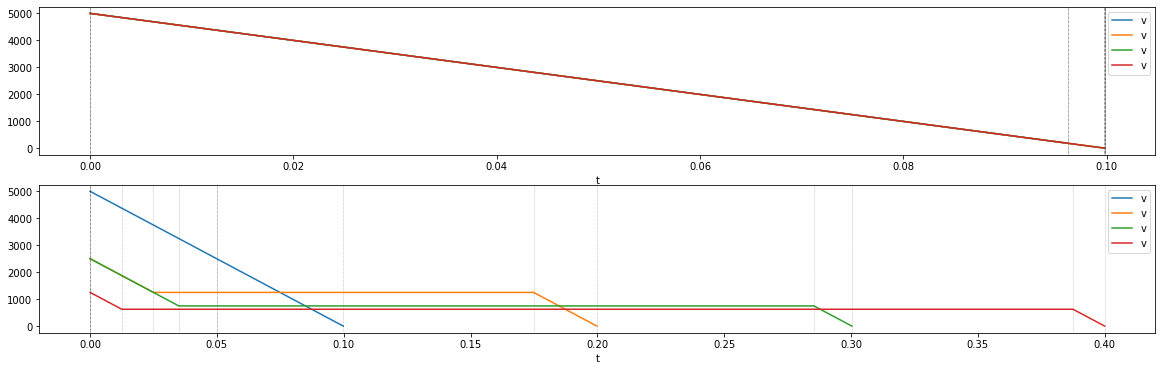

In [11]:
j = Joint(5_000, 50_000)

x = 249
v_0 = 5000
v_1 = 0

fig, ax = plt.subplots(2,1, figsize = (20, 6))
b = j.new_block(x, v_0, v_1).init()
end = .4
for t in np.linspace(b.t, end, num=4):
    b.plan_ramp(t)
    plot_params(b, ax=ax[0])

b = j.new_block(x, v_0, v_1).init()
for t in np.linspace(b.t, end, num=4):
    b.plan(t)
    plot_params(b, ax=ax[1])
    
    

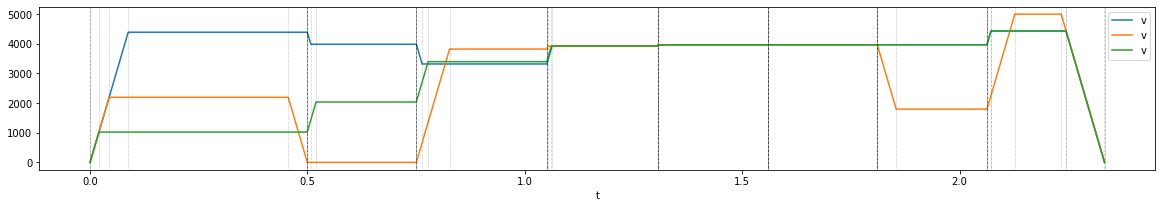

In [12]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([2000,1000,500])
s = sl.rmove([1000,0,500])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,500,1000])
s = sl.rmove([1000,1000,1000])


sl.plot()


,t,seg,axis,x,v_i,v_f,ss,del_t,calc_x,err
0,0.051042,0,0,65.0,0.00,2552.08,a,0.051042,65.131251,-0.131251
1,0.299772,0,0,635.0,2552.08,2552.08,c,0.248730,634.779879,0.220121
2,0.299807,0,0,0.0,2552.08,2550.36,d,0.000034,0.088017,-0.088017
3,0.099935,0,1,250.0,0.00,4996.74,a,0.099935,249.674356,0.325644
4,0.200130,0,1,501.0,4996.74,4996.74,c,0.100195,500.650363,0.349637
5,0.300065,0,1,250.0,4996.74,0.00,d,0.099935,249.674356,0.325644
6,0.299841,1,0,0.0,2550.36,2552.08,a,0.000034,0.088017,-0.088017
7,0.548571,1,0,635.0,2552.08,2552.08,c,0.248730,634.779879,0.220121
8,0.599613,1,0,65.0,2552.08,0.00,d,0.051042,65.131251,-0.131251
9,0.400000,1,1,-250.0,0.00,-4996.74,a,0.099935,-249.674356,-0.325644


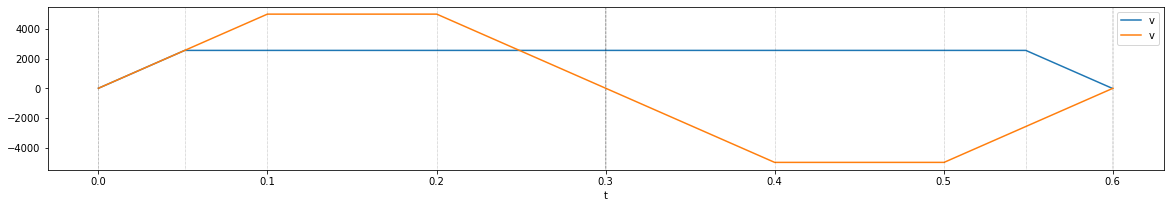

In [13]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

def planr(s):
    
    if s.prior:
        s.prior.init().plan('R')
        
    s.update_0_boundary()
    s.plan()
    
    if s.prior:
        s.prior.update_1_boundary()
        s.prior.plan()

sl = SegmentList(joints)   
s = sl.rmove([700,1000], planner=planr)
s = sl.rmove([700,-1000], planner=planr)
#s = sl.rmove([-1000,-1000], planner=planr)
#s = sl.rmove([-1000,1000], planner=planr)

#sl[0].init()#.plan(update_bv=True)
#sl[1].init()
 
   
df = sl.dataframe
#df = df[df.axis==1]
plot_trajectory(df)
df

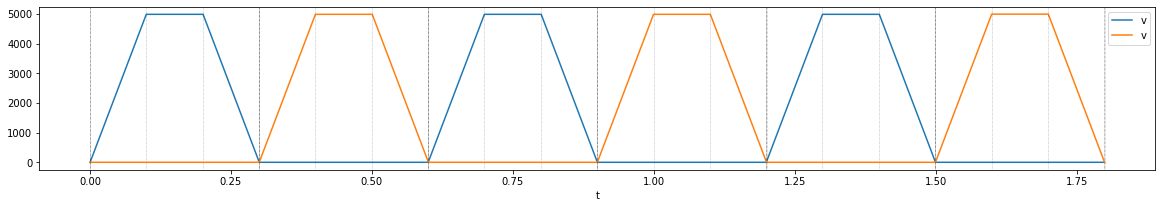

In [14]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.rmove([1000,1])
s = sl.rmove([1,1000])
s = sl.rmove([1000,1])
s = sl.rmove([1,1000])
s = sl.rmove([1000,1])
s = sl.rmove([1,1000])

sl.plot()


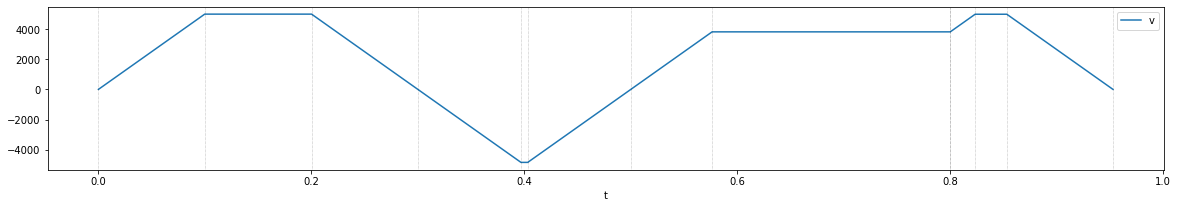

In [15]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*1

sl = SegmentList(joints)   
s = sl.rmove([1000])
s = sl.rmove([-500])
s = sl.rmove([1000])
s = sl.rmove([500])


sl.plot()

In [16]:
%reload_ext autoreload
%autoreload 2

# Immediate convergence error
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*4
sl = SegmentList(joints)   
sl.rmove([160, 669, 991, 0])
sl.rmove([163, 529, 414, 369])
sl.rmove([-494, 733, 914, 0])
sl.rmove([-133, 0, 0, -596])
sl.rmove([-383, 606, 35, -955])
sl.rmove([-528, 583, 0, -868])
sl.rmove([-11, 0, 710, -524])
sl.rmove([-924, 658, 957, -940])
sl.rmove([-379, 110, 771, -275])


print(sl[-1].times, sl[-1].times_e_rms)

[0.254259, 0.253896, 0.25436, 0.253896] 0.0004196221514648415


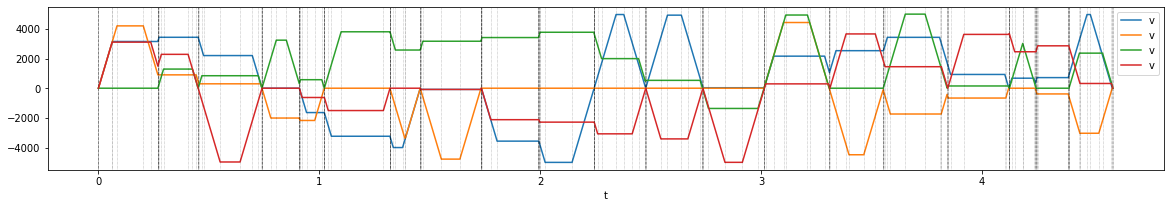

In [23]:
from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from random import random, randint

j = Joint(5_000, 50_000)
n = 4
joints = [j]*n
signs = [1]*n

sl = SegmentList(joints)   

def iz():
    # 
    return 

def rand_move(axis):

    z = int(random() < .9) # Make 10% of the moves zero
    if random() < .1: # change direction 10% of the time
        signs[axis] = -signs[axis]

    return z * signs[axis] * randint(0,1000)
 

move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(20) ]
        

for move_n, moves in enumerate(move_sets):
    try:
        sl.rmove(moves)
    except:
        print("Move=", move_n, move_sets[move_n])
        raise
     
df = sl.dataframe
df = df[df.axis==0]
sl.plot()

/Users/eric/Documents/proj/trajectory/trajectory/planner.py:575: UserWarning: Failed to converge sid={self.n} with err > 0.001, but < 0.003
  warn("Failed to converge sid={self.n} with err > 0.001, but < 0.003")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 60/0d@-21.77 -> 61/0a@-10.89
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 146/0d@73.95 -> 147/0a@0.29
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 158/0d@194.97 -> 159/0a@48.74
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 179/0d@1073.2 -> 180/0a@536.6
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 208/

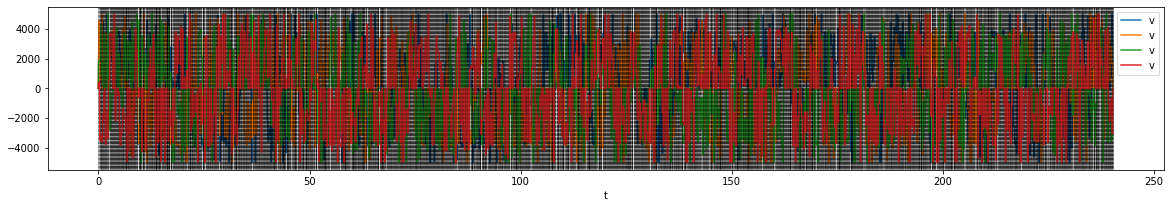

In [18]:
sl = SegmentList(joints) 
for i, moves in list(enumerate(move_sets))[:move_n+1]:
    try:
        sl.rmove(moves)
    except:
        print("Move=", i)
        raise
        
#sl.plot()

In [19]:
for m in move_sets[move_n-10:move_n+1]:
    print(f"sl.rmove({m})")

sl.rmove([97, 490, 203, 353])
sl.rmove([92, -245, -879, 30])
sl.rmove([852, -724, 351, 177])
sl.rmove([484, 652, 178, 595])
sl.rmove([87, 259, 985, 1])
sl.rmove([223, 751, -828, 753])
sl.rmove([0, 769, -356, -198])
sl.rmove([0, 674, -297, -389])
sl.rmove([542, 506, -359, -359])
sl.rmove([240, 655, -803, -169])
sl.rmove([930, 441, -772, -678])


In [20]:
print(move_sets[8])
sl.rmove([-9923, -9556, -1264, 2736])

[611, 262, 842, -758]


0.0000|[0       -249↗ -9423@4999  ↘-249       0] [0       -230↗ -9094@4805  ↘-230       0] [2826     -76↗ -1184@583   ↘-3         0] [0         17↗  2701@1329  ↘17         0]